In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data processing

Data directory location

In [2]:
data_dir = "data"

Set the image size (for resizing); batch size and seed 

In [3]:
batch_size = 32
image_size = (224,224)
seed = 10
validation_split = 0.3

Load in all images from the data directory

In [4]:
train_dataset = image_dataset_from_directory(data_dir, shuffle=True,image_size=image_size, subset= "training",validation_split = validation_split, seed = seed)
val_dataset = image_dataset_from_directory(data_dir, shuffle=True,image_size=image_size, subset= "validation",validation_split = validation_split, seed = seed)

Found 20933 files belonging to 42 classes.
Using 14654 files for training.
Found 20933 files belonging to 42 classes.
Using 6279 files for validation.


Let's look at the first nine images from the train dataset

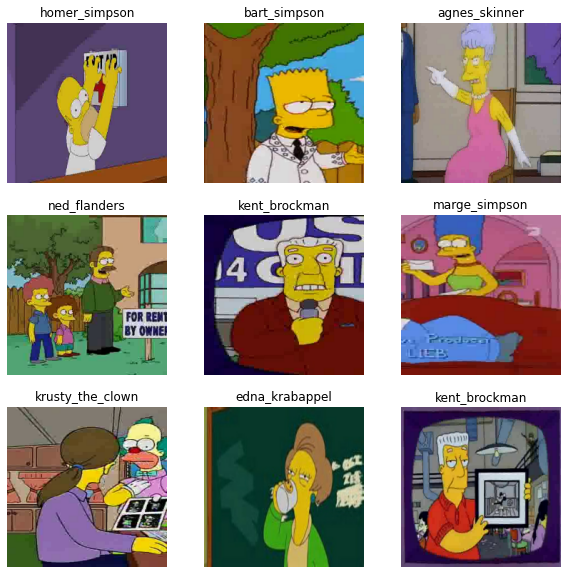

In [6]:
class_names = train_dataset.class_names
no_classes = len(class_names)
plt.figure(figsize=(10,10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Now get a test dataset from the validation set

In [7]:
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 5)
val_dataset = val_dataset.skip(val_batches // 5)

In [8]:
print("Number of train batches: {}".format(tf.data.experimental.cardinality(train_dataset)))
print("Number of validation batches: {}".format(tf.data.experimental.cardinality(val_dataset)))
print("Number of test batches: {}".format(tf.data.experimental.cardinality(test_dataset)))

Number of train batches: 458
Number of validation batches: 158
Number of test batches: 39


Configure dataset for performance

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Chosing resnet50 as the pretrained model 

In [11]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

## Loading the pre-trained model

- Chosing resnet50 as the pretrained model
- Chosing the bottleneck layer as the layer to use for feature extraction

Create and instance of resnet50 pre-loaded with weights trained on ImageNet. include_top=False means the loaded network doesn't include classification layers, useful for feature extraction

In [33]:
image_shape = image_size + (3,)
print(image_shape)
base_model = tf.keras.applications.ResNet50(input_shape=image_shape,
                                               include_top=False,
                                              )

(224, 224, 3)


This feature extractor converts each 224x224x3 image into a 7x7x2048 block of features. Let's see what it does to an example batch of images:

In [44]:
image_batch, label_batch = next(iter(train_dataset))
# feature_batch= base_model(image_batch)
# print(feature_batch.shape)

### feature extraction

Freeze the convolutional base

In [45]:
base_model.trainable = False

Details on the model:

In [46]:
# base_model.summary()

Set a global average layer

In [47]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

Add a prediction layer, 42 for the number of classes

In [48]:
prediction_layer = tf.keras.layers.Dense(no_classes)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

Set input shape, add the augmentation, processing

In [49]:
inputs = tf.keras.Input(shape=(224,224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Set learning rate, and compile the model

In [62]:
base_learning_rate = 0.1
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
# model.summary()

In [64]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(val_dataset)

158/158 [==============================] - 296s 2s/step - loss: 4.4079 - accuracy: 0.0049


In [65]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.43
initial accuracy: 0.01


In [66]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/10
458/458 [==============================] - 1147s 2s/step - loss: 42.1238 - accuracy: 0.4460 - val_loss: 32.3577 - val_accuracy: 0.5180
Epoch 2/10
458/458 [==============================] - 1126s 2s/step - loss: 27.3512 - accuracy: 0.6059 - val_loss: 27.6302 - val_accuracy: 0.6508
Epoch 3/10
458/458 [==============================] - 1614s 4s/step - loss: 24.9616 - accuracy: 0.6520 - val_loss: 28.4812 - val_accuracy: 0.6693
Epoch 4/10
458/458 [==============================] - 1141s 2s/step - loss: 24.3392 - accuracy: 0.6853 - val_loss: 31.1794 - val_accuracy: 0.6651
Epoch 5/10
458/458 [==============================] - 1209s 3s/step - loss: 23.9236 - accuracy: 0.7032 - val_loss: 28.9333 - val_accuracy: 0.6979
Epoch 6/10
458/458 [==============================] - 1240s 3s/step - loss: 24.3816 - accuracy: 0.7182 - val_loss: 30.6294 - val_accuracy: 0.7064
Epoch 7/10
458/458 [==============================] - 1199s 3s/step - loss: 23.8705 - accuracy: 0.7319 - val_loss: 32.3201 -

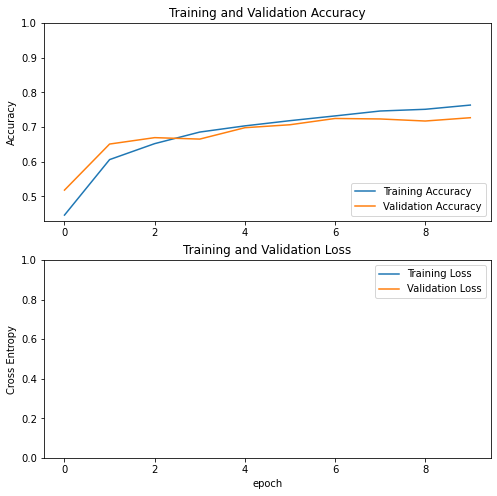

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()